AL, 2022-01-16

# Brain tumor 3D segmentation with MONAI

This notebook is essentially a copy of the `brats_segmentation_3d.ipynb` notebook from https://github.com/Project-MONAI/tutorials. We will not have time for a detailed introduction to MONAI. Please consult the documentation: https://monai.io.

This notebook on Colab (unfortunately unsuccessful): [![Open this demo in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2022/blob/main/Lab4-BRATS/ELMED219-2022-Lab4-BRATS-segmentation-3D-MONAI.ipynb)

The corresponding MONAI tutorial notebook: [![Open MONAI tutorial in Colab](https://colab.research.google.com/assets/colab-badge.svg)]((https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb))

The tutorial notebook shows how to construct a training workflow of a **multi-labels segmentation task**:<br>

- _Obtain pre-defined biologically/clinically significant subregions of a brain tumor from multiparametric 3D MRI recordings using supervised learning with 3D convolutional deep neural networks_, i.e.

##  Multilabel tumor segmentation:  $y  \approx f(X; \theta)$

### Data $X$:

In our case we are using multiparametric magnetic resonance images ([mp-MRI](https://en.wikipedia.org/wiki/MRI_sequence)) recordings from previous BraTS challenges openly available in the **Medical Segmentation Decathlon** ([MSD](https://arxiv.org/abs/2106.05735)) repository (http://medicaldecathlon.com) as `Task01_BrainTumor.tar` (see also https://decathlon-10.grand-challenge.org).

The data set consists of 750 mp-MRI recordings from patients diagnosed with either glioblastoma or lower-grade glioma (LGG). The sequences used were native
T1-weighted (T1), post-Gadolinium (Gd) contrast T1-weighted (T1-Gd), native T2-weighted (T2),
and T2 Fluid-Attenuated Inversion Recovery (FLAIR). The corresponding target ROIs were the
three tumor sub-regions, namely edema, enhancing, and non-enhancing tumor. This data set was
selected due to the challenge of locating these complex and heterogeneously-located targets. The
data was acquired from 19 different institutions and contained a subset of the data used in the
[2016](https://www.smir.ch/BRATS/Start2016) and [here](https://paperswithcode.com/dataset/brats-2016) and [2017](https://www.med.upenn.edu/sbia/brats2017.html) Brain Tumor Segmentation (BraTS) challenges [12, 13, 14].

There are a total of 750 4D volumes available, 484 four-channel MRI images (`imagesTr` folder) with corresponding multi-label images (`labelsTr`) available for training, and 266 mpMRI recordings (no corresponding labels provided) in the `ìmagesTs`folder. The provided data are distributed after their pre-processing, i.e. co-registered to the same anatomical template, interpolated to the same resolution (1 mm$^3$) and skull-stripped. 


REMARK: A slight discrepancy
```python
import os
home = os.path.expanduser('~')
DIRS = ['imagesTr', 'labelsTr', 'imagesTs']
for DIR in DIRS:
    myDIR = f'{home}/prj/ELMED219/BRATS_DATA/Task01_BrainTumour/{DIR}'
    print(f'{DIR}: {len([name for name in os.listdir(myDIR) if os.path.isfile(os.path.join(myDIR, name))])}')
    
imagesTr: 495
labelsTr: 485
imagesTs: 289
```

### Labels and classes $y$:

In this challenge we have the following **labels** for the data:
  - label 0 is non-tumor
  - label 1 is the peritumoral edema
  - label 2 is the necrotic and non-enhancing tumor core
  - label 3 is the GD-enhancing tumor

The possible **classes** are:
  - TC (Tumor core)
  - WT (Whole tumor)
  - ET (Enhancing tumor)

(merging label 2 and label 3 to construct TC, merging labels 1, 2 and 3 to construct WT, and label 3 is ET)

![img](https://github.com/MMIV-ML/ELMED219-2022/blob/main/Lab4-BRATS/assets/ELMED219-2022-Lab4-BraTS-data.png?raw=true)

In [2]:
from IPython.display import Image
#Image(filename='./assets/ELMED219-2022-Lab4-BraTS-data.png', width=900) 

### Model $f$ and trainable parameters $\theta$:

In our $y  \approx f(X; \theta)$ notation we will for each voxel location $v \in \Omega(X)$ (spatial domain of the multiparametric brain image $X$) have


- $y_v \in \{y_1, y_2, y_3, y_4\}$ = {_TC_, _WT_, _ET_, non-tumor} (these regions are illustrated in the figure below)


- $f$ is a 3D convolutional deep neural net model (i.e. `SegResNet`), and 


- $\theta = (\theta_1, \theta_2, ...., \theta_p)$ is the $p$ trainable model parameters (``synaptic weights") in $f$ (in our `SegResNet` model $p \sim 4.7 \cdot 10^6$), and


- $\approx$ denotes _approximation_ expressed by a loss function or performance metric such as the Dice coefficient for the segmentation, e.g. accross one epoch during training: 


Example from some epochs training the model $f$ (SegResNet) on a NVDIA RTX A5000 GPU Laptop:
```
  epoch 1 average loss: 0.9190
  saved new best metric model
  current epoch: 1 current mean dice: 0.4148 tc: 0.4330 wt: 0.5984 et: 0.2131
  best mean dice: 0.4148 at epoch: 1
  time consuming of epoch 1 is: 337.8720  (in seconds using a NVIDIA RTX A5000 GPU)
  ----------
  epoch 60 average loss: 0.1837
  current epoch: 60 current mean dice: 0.7540 tc: 0.8043 wt: 0.8966 et: 0.5611
  best mean dice: 0.7650 at epoch: 54
  time consuming of epoch 60 is: 339.6923
  ----------
```
Training 300 epochs using a slightly more powerful NVIDIA RTX 6000 GPU workstation:
```
   epoch 300 average loss: 0.1286
   current epoch: 300 current mean dice: 0.7913 tc: 0.8398 wt: 0.9139 et: 0.6201
   best mean dice: 0.7918 at epoch: 276
   time consuming of epoch 300 is: 272.1563
   CPU times: user 19h 52min 22s, sys: 1h 55min 29s, total: 21h 47min 51s
   Wall time: 22h 27min 4s
   
   train completed, best_metric: 0.7918 at epoch: 276, total time: 80824.40817975998.
```

And it contains the following steps:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](./assets/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).



### Note on BraTS 2021

- **[NVIDIA Data Scientists](https://developer.nvidia.com/blog/nvidia-data-scientists-take-top-spots-in-miccai-2021-brain-tumor-segmentation-challenge) Take Top Spots in MICCAI 2021 [Brain Tumor Segmentation Challenge](http://www.braintumorsegmentation.org)**:


 - Optimized U-Net for Brain Tumor Segmentation – Rank #1 (based on [`nnU-Net`](https://github.com/MIC-DKFZ/nnUNet) winner of [BraTS 2020](https://www.med.upenn.edu/cbica/brats2020) by [Isense et al.](https://arxiv.org/abs/2011.00848))
  
  
 - SegResNet: Redundancy Reduction in Semantic Segmentation of 3D Brain MRIs – Rank #2<br> The main model is the SegResNet architecture from MONAI, a standard encoder-decoder based convolutional neural network (CNN) similar to U-Net. 
  
![SegResNet](https://developer-blogs.nvidia.com/wp-content/uploads/2021/09/BRaTS-fig-2.png)
  
_A typical segmentation example with predicted labels overlaid overT1c MRI axial, sagittal and coronal slices. The whole tumor (WT) class includes all visible labels (a union of green, yellow and red labels), the tumor core (TC) class is a union of red and yellow, and the enhancing tumor core (ET) class is shown in yellow
(a hyperactive tumor part)._


## Setup environment

In [3]:
colab = False

In [4]:
if colab:
    !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
    !python -c "import matplotlib" || pip install -q matplotlib
    !pip install ignite


## Setup imports

In [5]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

%matplotlib inline
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
home = os.path.expanduser('~')  # To make path to local home directory
import pickle

# Here is the MONAI stuff we need
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 0.9.dev2202
Numpy version: 1.20.1
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: f320c275fadb39b659274476fb35d450b8cfbdc0
MONAI __file__: /home/arvid/anaconda3/envs/elmed219-brats/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.10.0a0
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.3.2
transformers version: 4.15.0
mlflow version: 1.22.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



On a Dell Precision 7560 Laptop with a NVIDIA RTX A5000 GPU
```
MONAI version: 0.9.dev2202
Numpy version: 1.20.1
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: f320c275fadb39b659274476fb35d450b8cfbdc0
MONAI __file__: /home/arvid/anaconda3/envs/bortem-brats/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.10.0a0
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.3.2
transformers version: 4.15.0
mlflow version: 1.22.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies
```

In [5]:
# Check if nvidia GPU is installed
!nvidia-smi

Sun Jan 16 21:51:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A500...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8    18W /  N/A |     10MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

`os.makedirs(name)` will create the directory on given path, also if any intermediate-level directory don’t exists then it will create that too (Its just like mkdir -p command in linux).


In [6]:
if colab:
    print(f'We will make a tmp directory for the BRATS data on Colab!')
    #directory = None
    #MONAI_DATA_DIRECTORY = Path('/storage/brats') or /workspace/data/medical
else:
    brats_data_dir = f'{home}/prj/ELMED219/BRATS_DATA'
    os.makedirs(brats_data_dir, exist_ok=True)
    os.environ['MONAI_DATA_DIRECTORY']=brats_data_dir

In [7]:
directory = os.environ.get('MONAI_DATA_DIRECTORY')
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [8]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [9]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor  (label 2 should be necrotic /non-enhancing tumor core according to freeview)
    label 3 is the necrotic and non-enhancing tumor core (label 3 should be Gd-enhansing tumor according to freeview)
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET (NOTE: ET should be label 3 according to freeview inspection)
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

## Setup transforms for training and validation

In [10]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the defaut args to cache all the items for validation, it depends on your memory size.

In [11]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

2022-01-16 21:51:39,384 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-01-16 21:51:39,385 - INFO - File exists: /home/arvid/prj/ELMED219/BRATS_DATA/Task01_BrainTumour.tar, skipped downloading.
2022-01-16 21:51:39,385 - INFO - Non-empty folder exists in /home/arvid/prj/ELMED219/BRATS_DATA/Task01_BrainTumour, skipped extracting.


## Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


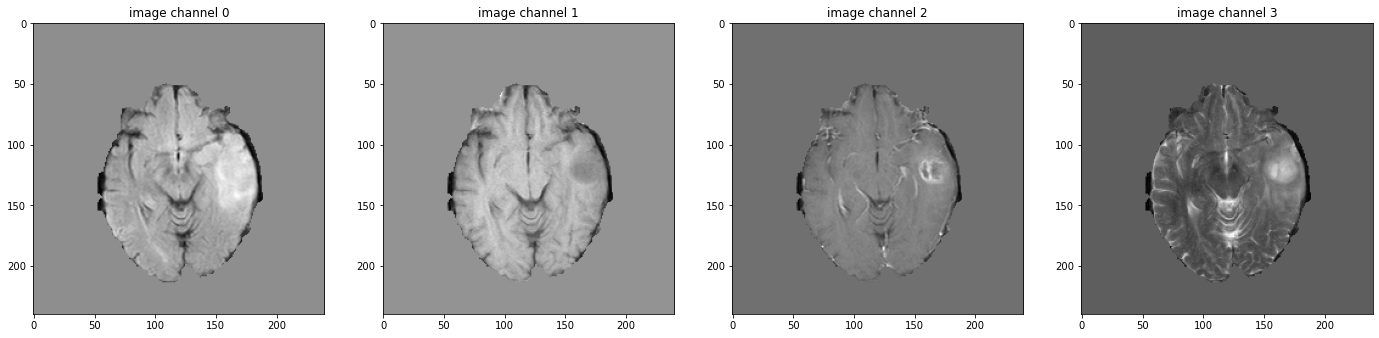

label shape: torch.Size([3, 240, 240, 155])


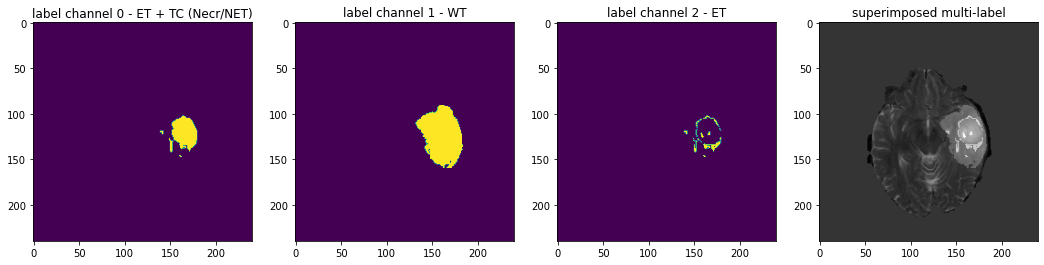

In [12]:
# pick one image from DecathlonDataset to visualize and check the 4 channels

nshape = val_ds[2]["image"][:, :, :, 60].detach().cpu().numpy().shape

img = np.zeros(nshape)
lab = np.zeros(nshape)

print(f"image shape: {val_ds[2]['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    img[i,:,:] = val_ds[2]["image"][i, :, :, 60].detach().cpu()
    if i < 3:
        lab[i,:,:] = val_ds[2]["label"][i, :, :, 60].detach().cpu()
    plt.imshow(np.rot90(img[i,:,:]), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[2]['label'].shape}")
plt.figure("label", (18, 6))


k=3 # template channel k=0,...,3
B = img[k,:,:]
mx = np.max(B)
c = mx/4
for i in range(3):
    B = B + (lab[i,:,:] * c*(i+1))

for i in range(3):
    plt.subplot(1, 4, i + 1)
    lab_i = val_ds[2]["label"][i, :, :, 60].detach().cpu()
    mxi = np.max(lab[i])
    if i==0:
        plt.title(f"label channel {i} - ET + TC (Necr/NET)")
    elif i==1:
        plt.title(f"label channel {i} - WT")
    else:
        plt.title(f"label channel {i} - ET")        
    plt.imshow(np.rot90(lab_i))

plt.subplot(1, 4, 4)
plt.title(f"superimposed multi-label")
plt.imshow(np.rot90(B/np.max(img[k,:,:])), cmap="gray")
plt.show()

## Create Model, Loss, Optimizer

In [13]:
if colab:
    max_epochs = 300
else:
    max_epochs = 1
    
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## Execute a typical PyTorch training process

In [14]:
%%time
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/1
1/388, train_loss: 0.9782, step time: 12.4895
2/388, train_loss: 0.9804, step time: 0.7037
3/388, train_loss: 0.9880, step time: 0.7040
4/388, train_loss: 0.9565, step time: 0.7104
5/388, train_loss: 0.9837, step time: 0.7090
6/388, train_loss: 0.9386, step time: 0.7123
7/388, train_loss: 0.9719, step time: 0.7143
8/388, train_loss: 0.9391, step time: 0.7157
9/388, train_loss: 0.9850, step time: 0.7015
10/388, train_loss: 0.9425, step time: 0.7105
11/388, train_loss: 0.8942, step time: 0.7045
12/388, train_loss: 0.8891, step time: 0.7090
13/388, train_loss: 0.9642, step time: 0.7141
14/388, train_loss: 0.8993, step time: 0.7119
15/388, train_loss: 0.9293, step time: 0.7094
16/388, train_loss: 0.9565, step time: 0.7161
17/388, train_loss: 0.9710, step time: 0.7113
18/388, train_loss: 0.9358, step time: 0.7104
19/388, train_loss: 0.9587, step time: 0.7110
20/388, train_loss: 0.8866, step time: 0.7082
21/388, train_loss: 0.9416, step time: 0.7090
22/388, train_loss: 0

178/388, train_loss: 0.9436, step time: 0.7155
179/388, train_loss: 0.9770, step time: 0.7074
180/388, train_loss: 0.9665, step time: 0.7184
181/388, train_loss: 0.9840, step time: 0.7101
182/388, train_loss: 0.8718, step time: 0.7240
183/388, train_loss: 0.9425, step time: 0.7104
184/388, train_loss: 0.9105, step time: 0.7154
185/388, train_loss: 0.9874, step time: 0.7089
186/388, train_loss: 0.9644, step time: 0.7223
187/388, train_loss: 0.8032, step time: 0.7327
188/388, train_loss: 0.9717, step time: 0.7200
189/388, train_loss: 0.9803, step time: 0.7221
190/388, train_loss: 0.9233, step time: 0.7350
191/388, train_loss: 0.9330, step time: 0.7204
192/388, train_loss: 0.9841, step time: 0.7232
193/388, train_loss: 0.9539, step time: 0.7211
194/388, train_loss: 0.9521, step time: 0.7093
195/388, train_loss: 0.8943, step time: 0.7206
196/388, train_loss: 0.9374, step time: 0.7133
197/388, train_loss: 0.8779, step time: 0.7158
198/388, train_loss: 0.9089, step time: 0.7152
199/388, trai

353/388, train_loss: 0.9313, step time: 0.7310
354/388, train_loss: 0.8958, step time: 0.7291
355/388, train_loss: 0.8162, step time: 0.7194
356/388, train_loss: 0.9696, step time: 0.7169
357/388, train_loss: 0.8518, step time: 0.7195
358/388, train_loss: 0.8987, step time: 0.7189
359/388, train_loss: 0.8473, step time: 0.7116
360/388, train_loss: 0.8427, step time: 0.7111
361/388, train_loss: 0.8733, step time: 0.7132
362/388, train_loss: 0.9212, step time: 0.7149
363/388, train_loss: 0.9154, step time: 0.7150
364/388, train_loss: 0.8819, step time: 0.7131
365/388, train_loss: 0.8444, step time: 0.7166
366/388, train_loss: 0.8960, step time: 0.7213
367/388, train_loss: 0.9410, step time: 0.7148
368/388, train_loss: 0.8879, step time: 0.7175
369/388, train_loss: 0.9854, step time: 0.7232
370/388, train_loss: 0.8316, step time: 0.7226
371/388, train_loss: 0.9737, step time: 0.7203
372/388, train_loss: 0.9524, step time: 0.7201
373/388, train_loss: 0.8896, step time: 0.7157
374/388, trai

In [15]:
for lst in ['best_metric_epoc', 'best_metrics_epochs_and_time', 'epoch_loss_values', 
           'metric_values', 'metric_values_tc', 'metric_values_wt', 'metric_values_et']:
    with open(f'./assets/ELMED219_BRATS_{lst}.pkl', 'wb') as f:
        pickle.dump(lst, f)

Training for 300 epochs during 22h 27min using a RTX 6000 GPU

```
----------
epoch 1/300
1/388, train_loss: 0.9782, step time: 12.6660
2/388, train_loss: 0.9804, step time: 0.5259
3/388, train_loss: 0.9880, step time: 0.4943
4/388, train_loss: 0.9565, step time: 0.4679
5/388, train_loss: 0.9837, step time: 0.4982
...

386/388, train_loss: 0.2119, step time: 0.5074
387/388, train_loss: 0.0507, step time: 0.5288
388/388, train_loss: 0.2687, step time: 0.5091
epoch 300 average loss: 0.1286
current epoch: 300 current mean dice: 0.7913 tc: 0.8398 wt: 0.9139 et: 0.6201
best mean dice: 0.7918 at epoch: 276
time consuming of epoch 300 is: 272.1563
CPU times: user 19h 52min 22s, sys: 1h 55min 29s, total: 21h 47min 51s
Wall time: 22h 27min 4s

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7918 at epoch: 276, total time: 80824.40817975998.

--> best_metric_model_5820_rtx6000_300epochs_20220115_1048.pth
```

In [16]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.4068 at epoch: 1, total time: 351.49999380111694.


#### Loading the `best_metric_model.pth` (after 22h 27min training over 300 epochs on a RTX 6000 GPU)

The NVIDIA RTX 6000 GPU workstation where the `best_metric_model_5820_rtx6000_300epochs_20220115_1048.pth` model was trained:
```
Fri Jan 14 13:40:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  On   | 00000000:65:00.0  On |                  Off |
| 33%   29C    P8    19W / 260W |    524MiB / 24197MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1357      G   /usr/lib/xorg/Xorg                 77MiB |
|    0   N/A  N/A      1852      G   /usr/lib/xorg/Xorg                207MiB |
|    0   N/A  N/A      1984      G   /usr/bin/gnome-shell               81MiB |
|    0   N/A  N/A      2914      G   ...AAAAAAAAA= --shared-files       30MiB |
|    0   N/A  N/A      7139      G   ...AAAAAAAAA= --shared-files       54MiB |
|    0   N/A  N/A     10037      G   /usr/lib/rstudio/bin/rstudio       57MiB |
|    0   N/A  N/A     15250      G   gnome-control-center                3MiB |
+-----------------------------------------------------------------------------+
```

In [17]:
PTH_file = './assets/best_metric_model_5820_rtx6000_300epochs_20220115_1048.pth'
best_model = model.load_state_dict(torch.load(PTH_file))

#### Get number of _trainable_ parameters

In [18]:
def count_parameters(model):
    '''
    torch.numel(p) total number of elements in the `input` tensor p
    '''

    return sum(torch.numel(p) for p in model.parameters() if p.requires_grad)

In [19]:
count_parameters(model)

4702227

## Plot the loss and metric

In [20]:
if colab:
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="red")
    plt.subplot(1, 2, 2)
    plt.title("Val Mean Dice")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="green")
    plt.show()

    plt.figure("train", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Val Mean Dice TC")
    x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
    y = metric_values_tc
    plt.xlabel("epoch")
    plt.plot(x, y, color="blue")
    plt.subplot(1, 3, 2)
    plt.title("Val Mean Dice WT")
    x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
    y = metric_values_wt
    plt.xlabel("epoch")
    plt.plot(x, y, color="brown")
    plt.subplot(1, 3, 3)
    plt.title("Val Mean Dice ET")
    x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
    y = metric_values_et
    plt.xlabel("epoch")
    plt.plot(x, y, color="purple")
    plt.show()

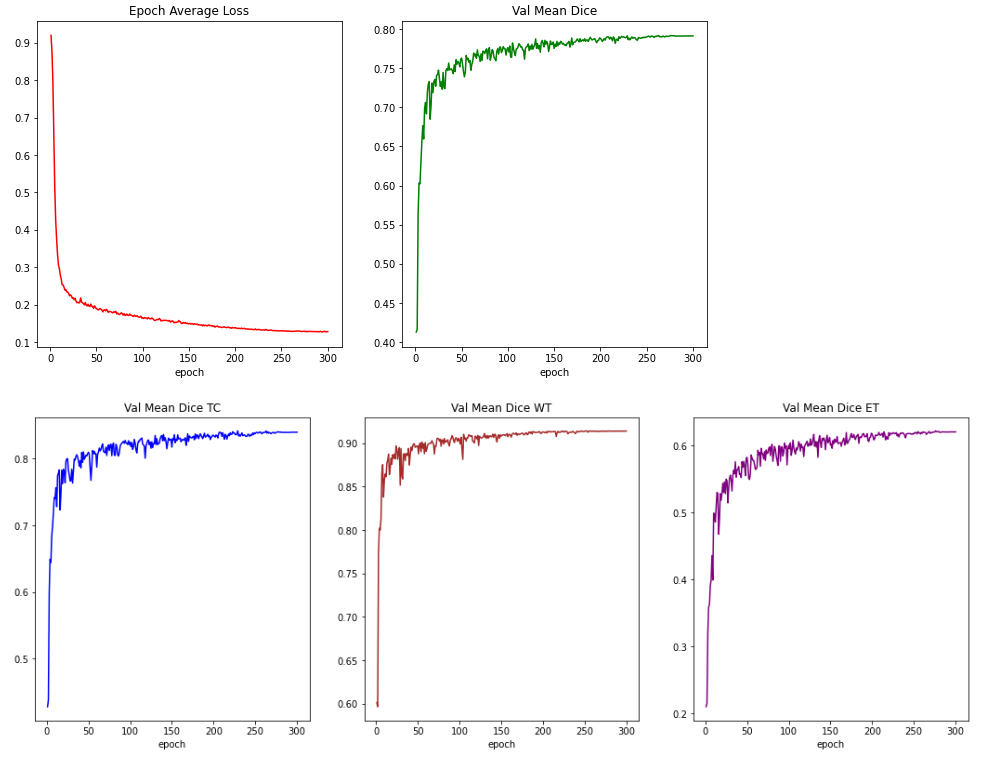

In [21]:
from IPython.display import Image
Image(filename='./assets/ELMED219_BRATS_DATA_300_epochs_loss_and_metric.png', width=900) 

## Check best model output with the input image and label

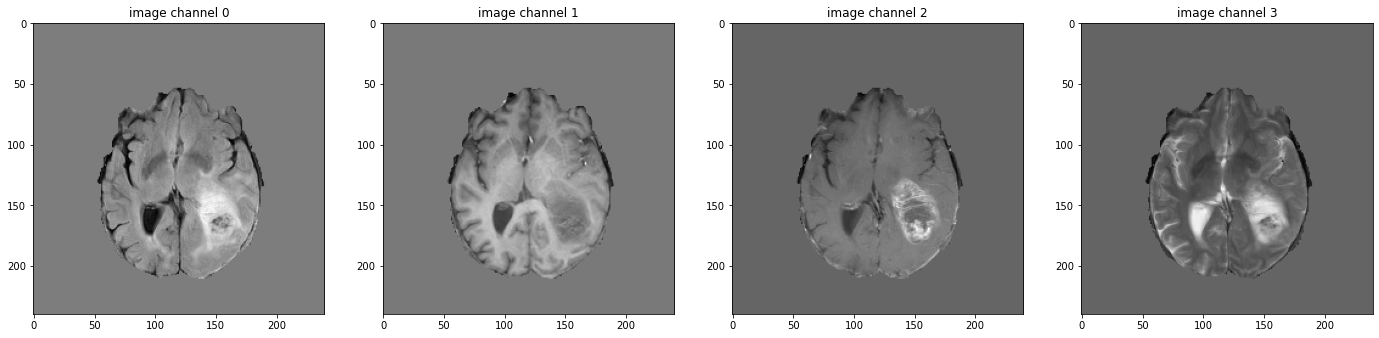

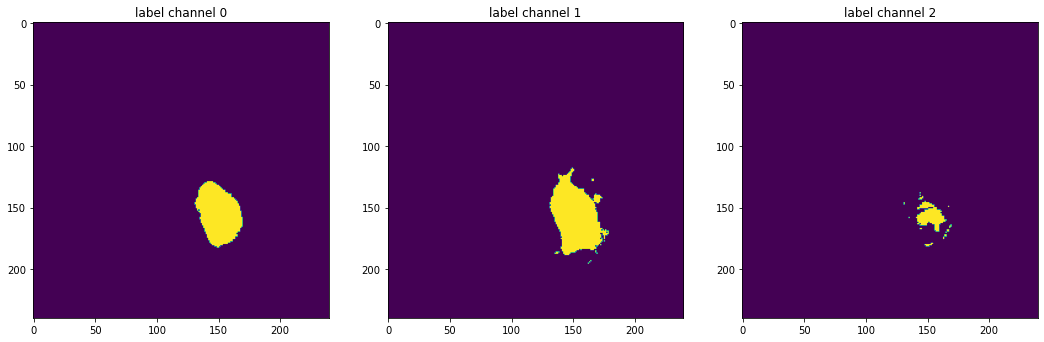

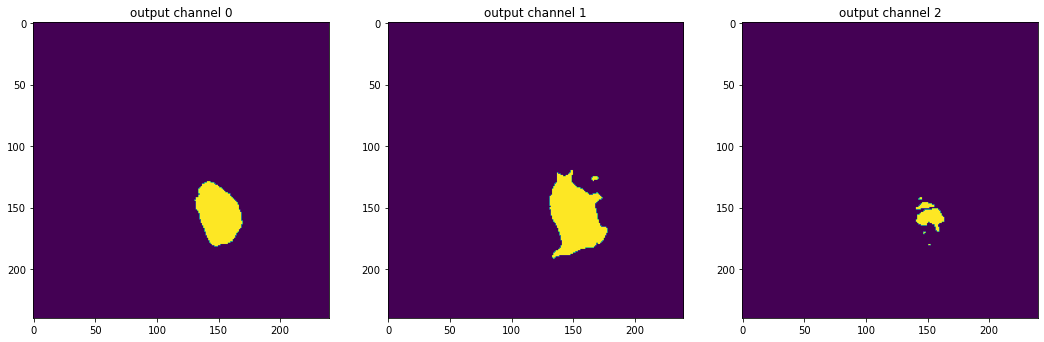

In [22]:
model.load_state_dict(
#    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
     torch.load(os.path.join('./assets', 'best_metric_model_5820_rtx6000_300epochs_20220115_1048.pth'))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(np.rot90(val_ds[6]["image"][i, :, :, 70].detach().cpu()), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(np.rot90(val_ds[6]["label"][i, :, :, 70].detach().cpu()))
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(np.rot90(val_output[i, :, :, 70].detach().cpu()))
    plt.show()

## Evaluation on original image spacings

In [23]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

In [24]:
if colab:
    model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
else:
    model.load_state_dict(
    torch.load(os.path.join('./assets', 'best_metric_model_5820_rtx6000_300epochs_20220115_1048.pth')))
    
model.eval()
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

print("Metric on original image spacing: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.4068244993686676
metric_tc: 0.4204
metric_wt: 0.5935
metric_et: 0.2066


### From the `best_metric_model.pth` (after 22h 27min training over 300 epochs on a RTX 6000 GPU):
```
Metric on original image spacing:  0.7912554740905762
metric_tc: 0.8398
metric_wt: 0.9139
metric_et: 0.6201
```

## Cleanup data directory

Remove directory if a temporary was used.

In [25]:
#if directory is None:
#    shutil.rmtree(root_dir)